In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [13, 6]


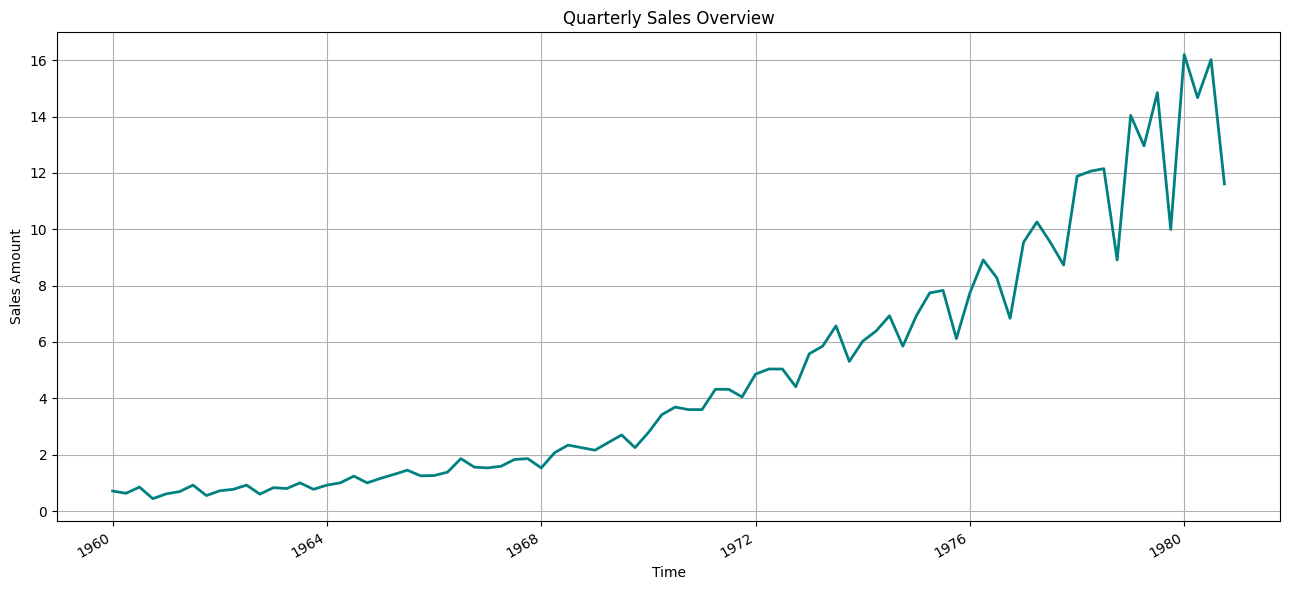

In [5]:
# Load the dataset and rename the target column for clarity
data = pd.read_csv('/content/jj.csv', parse_dates=['date'], index_col='date')
data.rename(columns={'data': 'sales'}, inplace=True)

# Initial time series plot to visualize the sales trend
data['sales'].plot(title='Quarterly Sales Overview', color='teal', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Sales Amount')
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:

from statsmodels.tsa.stattools import adfuller



# checks if the original series is stationary
result = adfuller(df['data'].dropna())
print('p-value (Original Series):', result[1])

# Perform ADF test on the first differenced series
# This helps to remove trend and stabilize the mean
result = adfuller(df['data'].diff().dropna())
print('p-value (After 1st Difference):', result[1])

# Perform ADF test on the second differenced series
# Useful if the first difference wasn't sufficient to make data stationary
result = adfuller(df['data'].diff().diff().dropna())
print('p-value (After 2nd Difference):', result[1])

p-value (Original Series): 1.0
p-value (After 1st Difference): 0.9088542416911305
p-value (After 2nd Difference): 0.006051099869603682


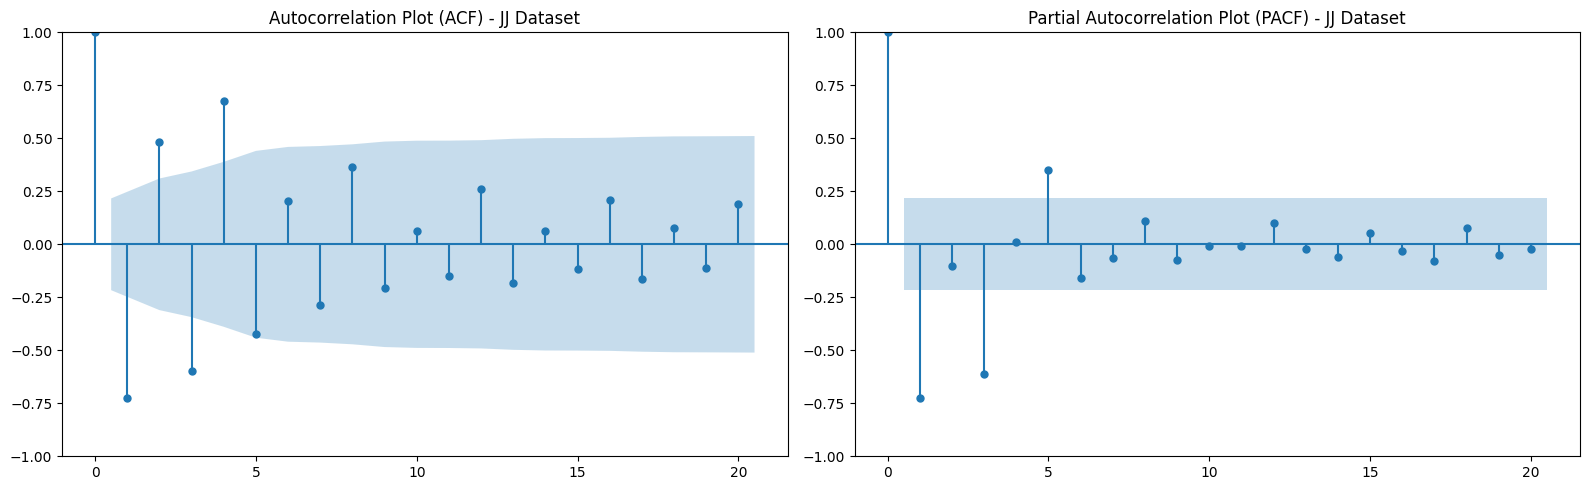

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # Create two side-by-side subplots

# Plot the Autocorrelation Function (ACF)
plot_acf(df['data'].diff().diff().dropna(), lags=20, ax=axes[0])
axes[0].set_title("Autocorrelation Plot (ACF) - JJ Dataset")

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(df['data'].diff().diff().dropna(), lags=20, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Plot (PACF) - JJ Dataset")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [9]:
# Grid search for best ARIMA order based on AIC
lowest_aic = np.inf
optimal_order = None
for p in range(4):
    for q in range(4):
        try:
            arima_model = ARIMA(data['sales'], order=(p, 2, q)).fit()
            if arima_model.aic < lowest_aic:
                optimal_order = (p, 2, q)
                lowest_aic = arima_model.aic
        except:
            continue
print("Selected ARIMA Order:", optimal_order)


Selected ARIMA Order: (3, 2, 3)


Optimal ARIMA order: (3, 2, 3)

ARIMA Evaluation (on last 8 quarters):
MAE  : 0.8624
RMSE : 1.0756
MAPE : 0.0586


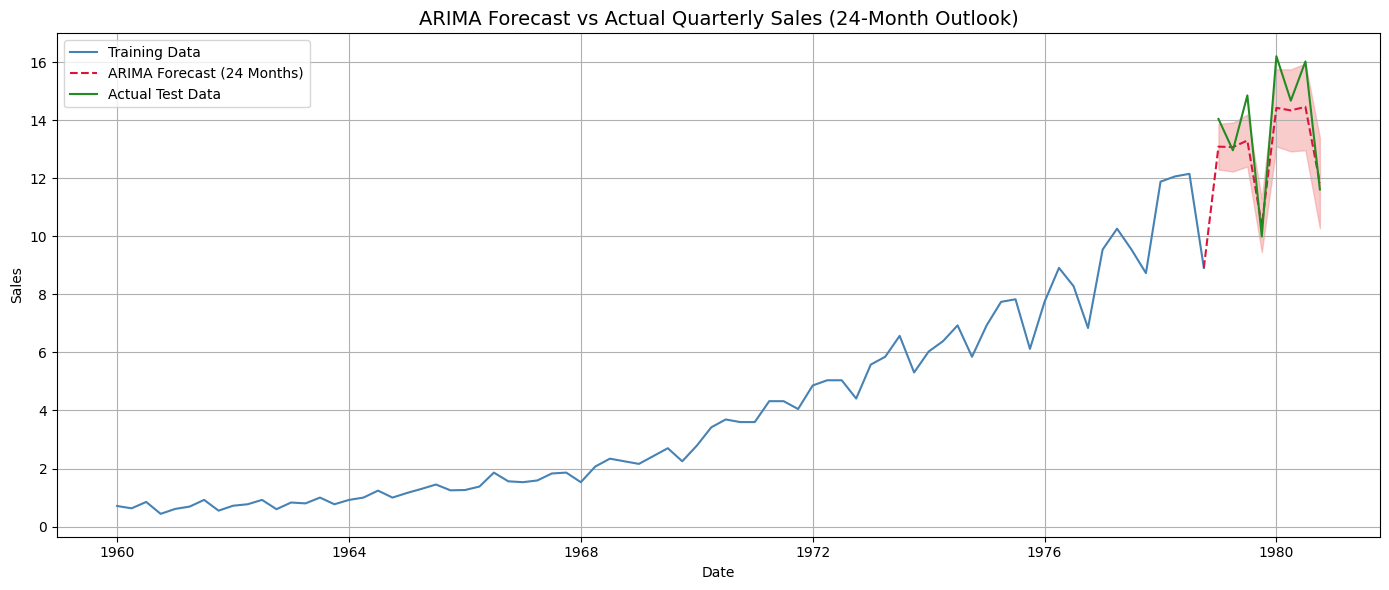

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# ---------------------------------------------------------
# Load dataset and prepare it for time series forecasting
# ---------------------------------------------------------
df = pd.read_csv('/content/jj.csv', index_col='date', parse_dates=True)
df.columns = ['data']  # Rename column for convenience

# ---------------------------------------------------------
# Determine optimal ARIMA(p, 2, q) configuration using AIC
# ---------------------------------------------------------
lowest_aic = float("inf")
best_order = None

for p in range(4):
    for q in range(4):
        try:
            model = ARIMA(df['data'], order=(p, 2, q)).fit()
            if model.aic < lowest_aic:
                lowest_aic = model.aic
                best_order = (p, 2, q)
        except:
            continue

print("Optimal ARIMA order:", best_order)

# ---------------------------------------------------------
# Split the dataset: last 8 quarters as test set
# ---------------------------------------------------------
test_len = 8
train_data = df[:-test_len]
test_data = df[-test_len:]

# ---------------------------------------------------------
# Train the ARIMA model on training data
# ---------------------------------------------------------
model = ARIMA(train_data['data'], order=best_order).fit()

# ---------------------------------------------------------
# Forecast the next 8 quarters
# ---------------------------------------------------------
forecast = model.get_forecast(steps=test_len)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()
forecast_index = test_data.index

# ---------------------------------------------------------
# Compute evaluation metrics for forecast performance
# ---------------------------------------------------------
y_true = test_data['data'].values
y_pred = forecast_mean.values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)

print("\nARIMA Evaluation (on last 8 quarters):")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.4f}")

# ---------------------------------------------------------
# Plot training, forecast, and actual values with styling
# ---------------------------------------------------------
plt.figure(figsize=(14, 6))

# Build a connected forecast line from the last train point
last_train_val = train_data['data'].iloc[-1]
last_train_date = train_data.index[-1]
forecast_series = pd.Series([last_train_val] + list(forecast_mean),
                            index=[last_train_date] + list(forecast_index))

# Plot training data in steelblue
plt.plot(train_data.index, train_data['data'], label='Training Data', color='steelblue')

# Plot ARIMA forecast in crimson dashed line
plt.plot(forecast_series.index, forecast_series, label='ARIMA Forecast (24 Months)', color='crimson', linestyle='--')

# Plot actual test values in forest green
plt.plot(test_data.index, test_data['data'], label='Actual Test Data', color='forestgreen')

# Confidence interval in light coral
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='lightcoral', alpha=0.4)

# Final layout adjustments
plt.title('ARIMA Forecast vs Actual Quarterly Sales (24-Month Outlook)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.1820 - val_loss: 0.2544
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0640 - val_loss: 0.1381
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0426 - val_loss: 0.1751
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0331 - val_loss: 0.0987
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0296 - val_loss: 0.1075
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0465 - val_loss: 0.1001
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0478 - val_loss: 0.1293
Epoch 8/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0322 - val_loss: 0.1395
Epoch 9/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0465 - val_loss: 0.1081
Epoch 10/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0309 - val_loss: 0.0966
Epoch 11/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0373 - val_loss: 0.0951
Epoch 12/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0315 - val_loss: 0.1380
E

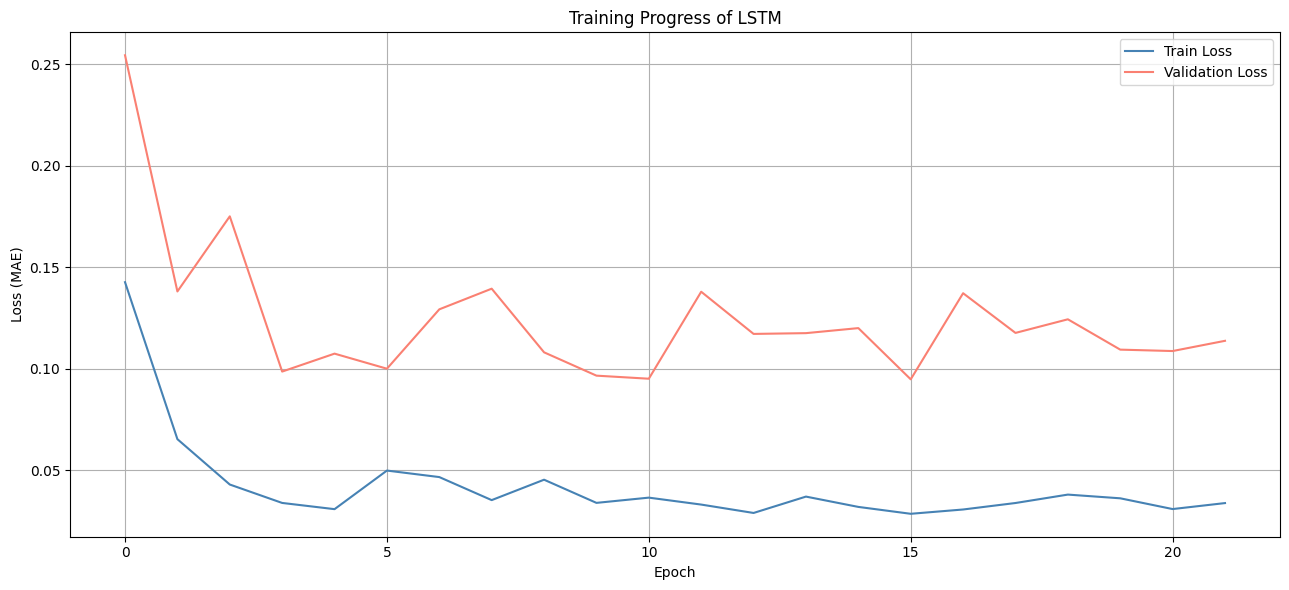

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step


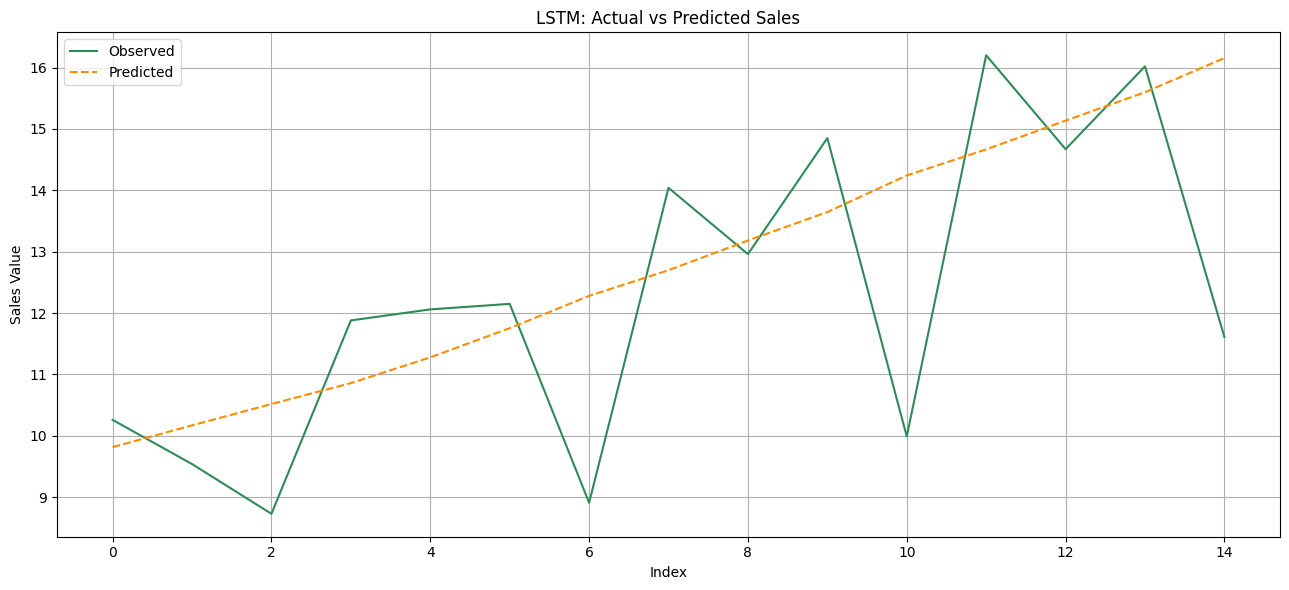

LSTM Model Evaluation:
MAE: 1.4945799413411458
RMSE: 2.0288365893402998
MAPE: 0.13596788490891423


In [12]:
# Function to prepare LSTM input sequences
# Normalize your dataset
scaler = MinMaxScaler()
normalized = scaler.fit_transform(data[['sales']])  # replace 'sales' if your column is named differently

# Function to prepare LSTM input sequences
def create_lstm_sequences(data, time_steps=12):
    X_seq, Y_seq = [], []
    for i in range(len(data) - time_steps):
        X_seq.append(data[i:i+time_steps])
        Y_seq.append(data[i+time_steps])
    return np.array(X_seq), np.array(Y_seq)

# Create sequences
X, y = create_lstm_sequences(normalized, 12)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Building the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dropout(0.25))
lstm_model.add(LSTM(32))
lstm_model.add(Dropout(0.25))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mae')

# Training LSTM model with early stopping
training_log = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=60,
    batch_size=8,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)]
)

# Visualize training performance
plt.plot(training_log.history['loss'], label='Train Loss', color='steelblue')
plt.plot(training_log.history['val_loss'], label='Validation Loss', color='salmon')
plt.title('Training Progress of LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predictions from LSTM and inverse transform
scaled_preds = lstm_model.predict(X_test)
y_predicted = scaler.inverse_transform(scaled_preds)
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted values
plt.plot(y_actual, label='Observed', color='seagreen')
plt.plot(y_predicted, label='Predicted', color='darkorange', linestyle='--')
plt.title('LSTM: Actual vs Predicted Sales')
plt.xlabel('Index')
plt.ylabel('Sales Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# LSTM Performance Metrics
print("LSTM Model Evaluation:")
print("MAE:", mean_absolute_error(y_actual, y_predicted))
print("RMSE:", np.sqrt(mean_squared_error(y_actual, y_predicted)))
print("MAPE:", mean_absolute_percentage_error(y_actual, y_predicted))

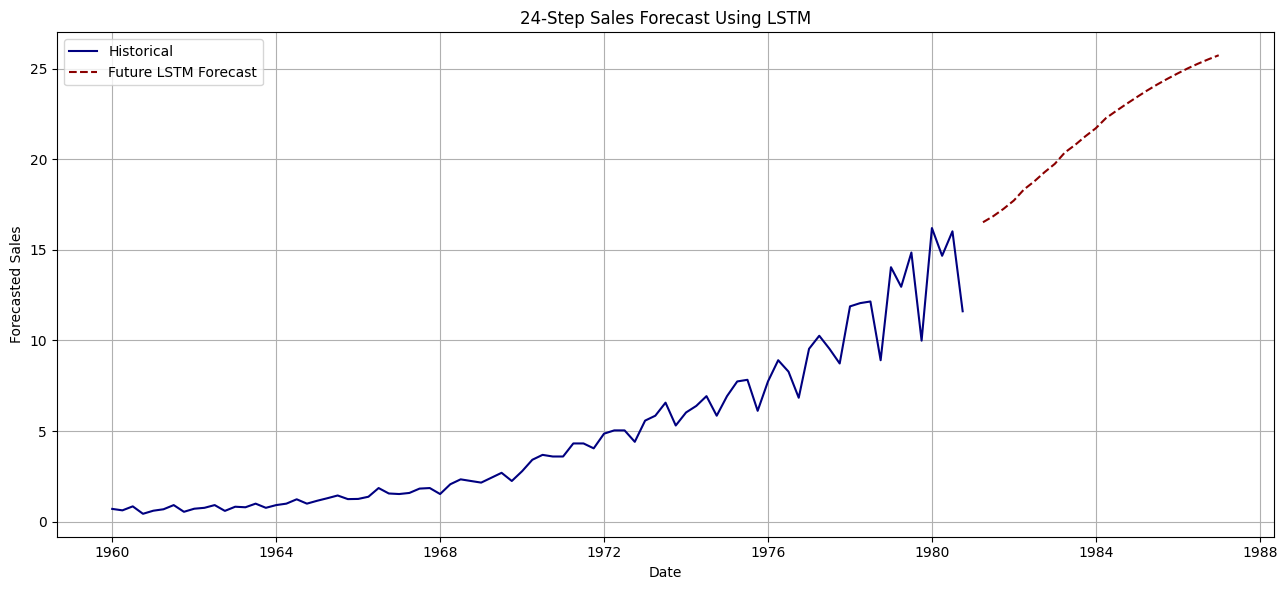

In [13]:
# Forecast future sales using the trained LSTM model
def forecast_lstm_future(model, recent_seq, steps=24, scaler=None):
    context = recent_seq[-12:].reshape(1, 12, 1)
    output = []
    for _ in range(steps):
        next_val = model.predict(context, verbose=0)[0][0]
        output.append(next_val)
        context = np.append(context[:, 1:, :], [[[next_val]]], axis=1)
    return scaler.inverse_transform(np.array(output).reshape(-1, 1))

# Generate predictions for future time steps
future_preds = forecast_lstm_future(lstm_model, normalized, steps=24, scaler=scaler)
prediction_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=3), periods=24, freq='Q')

# Final forecast plot
plt.plot(data.index, data['sales'], label='Historical', color='navy')
plt.plot(prediction_index, future_preds, label='Future LSTM Forecast', color='darkred', linestyle='--')
plt.title('24-Step Sales Forecast Using LSTM')
plt.xlabel('Date')
plt.ylabel('Forecasted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.1929 - val_loss: 0.3521
Epoch 2/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0797 - val_loss: 0.1724
Epoch 3/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0458 - val_loss: 0.1350
Epoch 4/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0344 - val_loss: 0.1090
Epoch 5/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0418 - val_loss: 0.1005
Epoch 6/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0368 - val_loss: 0.1292
Epoch 7/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0363 - val_loss: 0.1385
Epoch 8/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0374 - val_loss: 0.1036
Epoch 9/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0367 - val_loss: 0.1004
Epoch 10/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0403 - val_loss: 0.1001
Epoch 11/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0430 - val_loss: 0.1135
Epoch 12/60
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0358 - val_loss: 0.1254
E

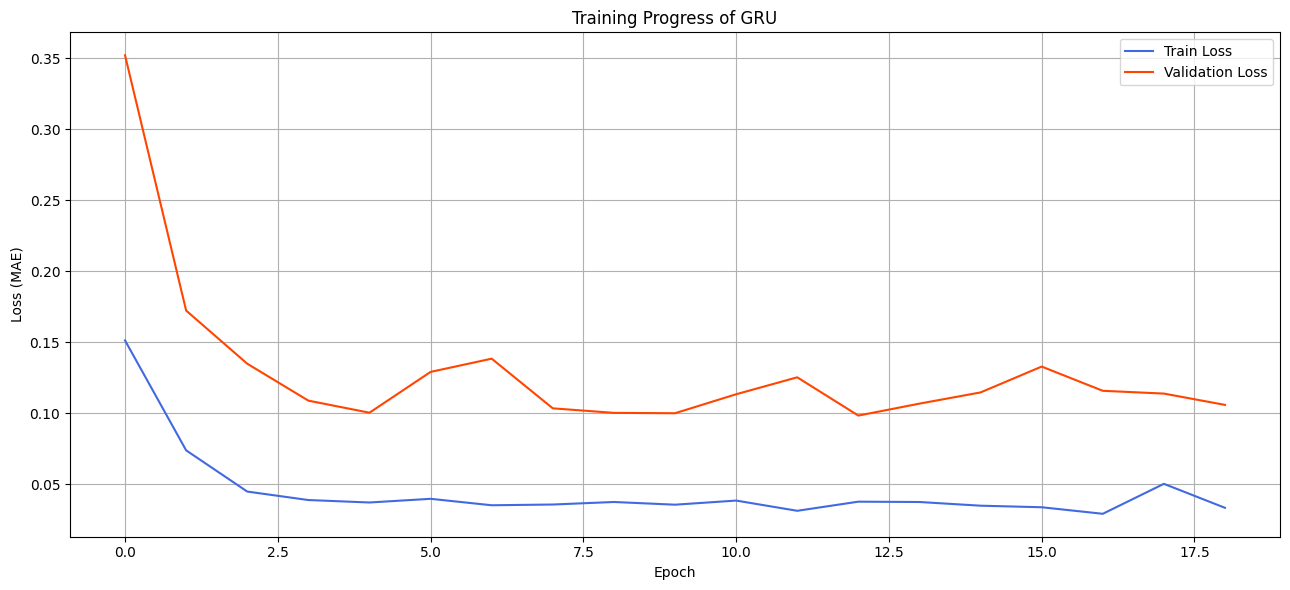

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step


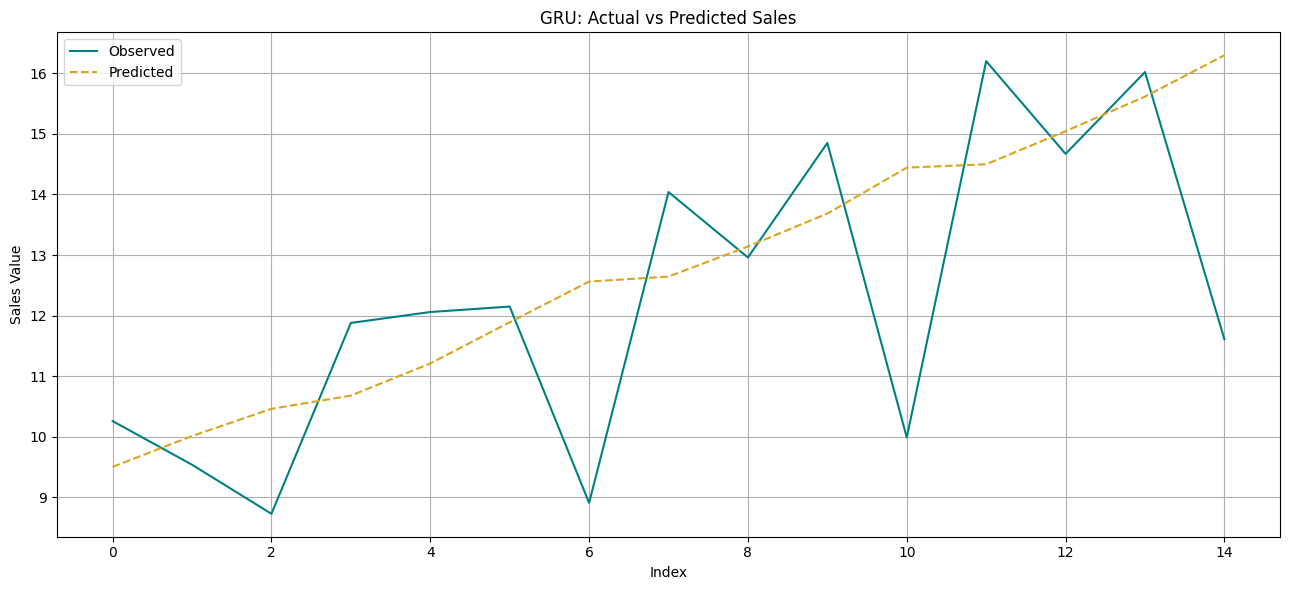

GRU Model Evaluation:
MAE: 1.5523415787109374
RMSE: 2.1244533312839935
MAPE: 0.14143359131372527


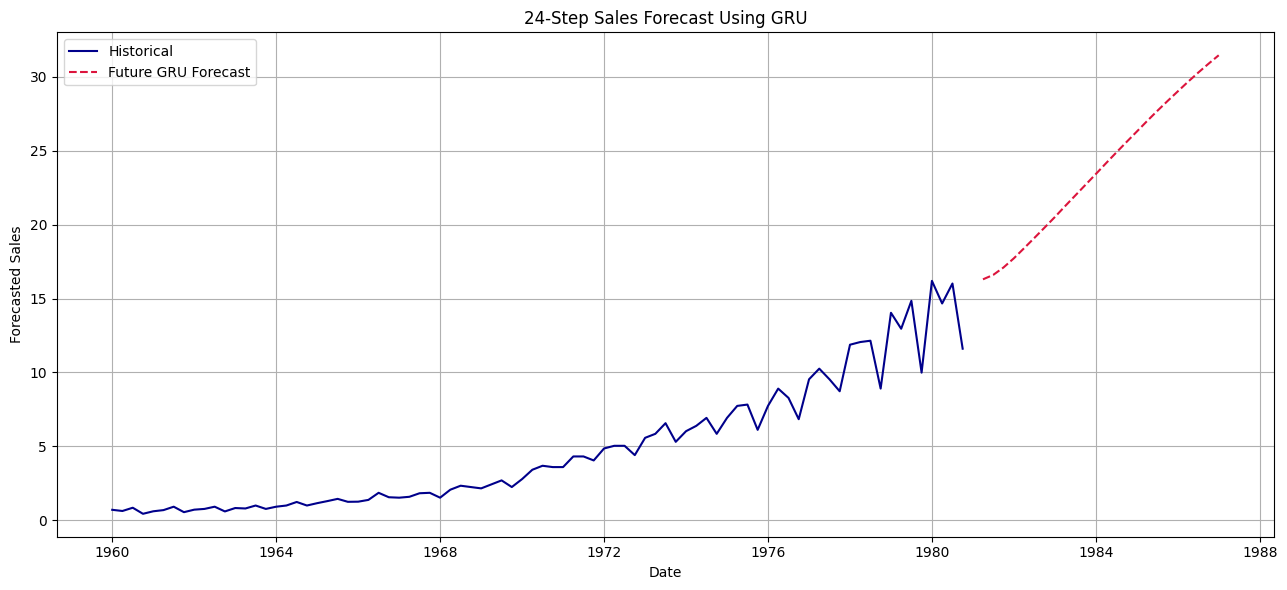

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# -----------------------------------------------------
# Step 1: Prepare Input Sequences for GRU Model
# -----------------------------------------------------
def create_gru_sequences(data, time_steps=12):
    X_seq, Y_seq = [], []
    for i in range(len(data) - time_steps):
        X_seq.append(data[i:i+time_steps])
        Y_seq.append(data[i+time_steps])
    return np.array(X_seq), np.array(Y_seq)

# -----------------------------------------------------
# Step 2: Create Sequences & Train-Test Split
# -----------------------------------------------------
X, y = create_gru_sequences(normalized, 12)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# -----------------------------------------------------
# Step 3: Build GRU Model Architecture
# -----------------------------------------------------
gru_model = Sequential()
gru_model.add(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
gru_model.add(Dropout(0.25))
gru_model.add(GRU(32))
gru_model.add(Dropout(0.25))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mae')

# -----------------------------------------------------
# Step 4: Train GRU Model with EarlyStopping
# -----------------------------------------------------
training_log = gru_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=60,
    batch_size=8,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)]
)

# -----------------------------------------------------
# Step 5: Plot Training Progress
# -----------------------------------------------------
plt.plot(training_log.history['loss'], label='Train Loss', color='royalblue')
plt.plot(training_log.history['val_loss'], label='Validation Loss', color='orangered')
plt.title('Training Progress of GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# Step 6: Make Predictions and Inverse Transform
# -----------------------------------------------------
scaled_preds = gru_model.predict(X_test)
y_predicted = scaler.inverse_transform(scaled_preds)
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# -----------------------------------------------------
# Step 7: Plot Observed vs Predicted Sales
# -----------------------------------------------------
plt.plot(y_actual, label='Observed', color='teal')
plt.plot(y_predicted, label='Predicted', color='goldenrod', linestyle='--')
plt.title('GRU: Actual vs Predicted Sales')
plt.xlabel('Index')
plt.ylabel('Sales Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------------
# Step 8: Display Performance Metrics
# -----------------------------------------------------
print("GRU Model Evaluation:")
print("MAE:", mean_absolute_error(y_actual, y_predicted))
print("RMSE:", np.sqrt(mean_squared_error(y_actual, y_predicted)))
print("MAPE:", mean_absolute_percentage_error(y_actual, y_predicted))

# -----------------------------------------------------
# Step 9: Forecast Future Sales (Next 24 Months)
# -----------------------------------------------------
def forecast_gru_future(model, recent_seq, steps=24, scaler=None):
    context = recent_seq[-12:].reshape(1, 12, 1)
    output = []
    for _ in range(steps):
        next_val = model.predict(context, verbose=0)[0][0]
        output.append(next_val)
        context = np.append(context[:, 1:, :], [[[next_val]]], axis=1)
    return scaler.inverse_transform(np.array(output).reshape(-1, 1))

# -----------------------------------------------------
# Step 10: Generate and Plot Future Forecast
# -----------------------------------------------------
future_preds = forecast_gru_future(gru_model, normalized, steps=24, scaler=scaler)
prediction_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=3), periods=24, freq='Q')

plt.plot(data.index, data['sales'], label='Historical', color='darkblue')
plt.plot(prediction_index, future_preds, label='Future GRU Forecast', color='crimson', linestyle='--')
plt.title('24-Step Sales Forecast Using GRU')
plt.xlabel('Date')
plt.ylabel('Forecasted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
